In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

from functions import *

In [2]:
metaData = pd.read_csv('../metaDataTrain.csv')
metaDataClean = metaData.iloc
metaData.head()

,Id,Category,Height,Weight,ed_maxmean,ed_stdmean,ed_meanstd,ed_std_std,ed_mean,ed_max,es_maxmean,es_stdmean,es_meanstd,es_std_std,es_mean,es_max
0,1,2,184.0,95.0,3.881778,0.916004,0.920320,0.199097,2.545188,5.656854,5.289519,1.064626,1.202439,0.326654,3.624038,8.000000
1,2,2,160.0,70.0,4.137292,0.951956,1.304753,0.373236,2.905463,8.485281,6.650502,1.521224,1.501470,0.356065,4.255417,12.000000
2,3,2,165.0,77.0,4.699254,0.956888,1.153515,0.268412,2.920028,7.810250,5.249486,1.138900,1.255835,0.432014,3.278909,8.544004
3,4,2,159.0,46.0,5.146465,1.231963,1.116522,0.123642,3.261632,7.810250,5.310376,1.204373,1.337397,0.296933,3.596841,8.944272
4,5,2,165.0,77.0,5.100857,1.161749,1.368049,0.339034,3.480619,8.062258,7.875007,2.089008,1.396219,0.276128,5.113233,12.041595


In [3]:
subject_list = load_training_dataset(metaDataClean)

## First approach: just use Height and Weight to predict the class

In [4]:
healthy = select_lines_where_class_value_is_X(metaDataClean, 0).iloc
myocardial_infarction = select_lines_where_class_value_is_X(metaDataClean, 1).iloc
dilated_cardiomyopathy = select_lines_where_class_value_is_X(metaDataClean, 2).iloc
hypertrophic_cardiomyopathy = select_lines_where_class_value_is_X(metaDataClean, 3).iloc
arrhythmogenic_right_ventricular_dysplasia = select_lines_where_class_value_is_X(metaDataClean, 4).iloc

healthy = select_row_x_and_y_from_table(healthy, 2, 3)
myocardial_infarction = select_row_x_and_y_from_table(myocardial_infarction, 2, 3)
dilated_cardiomyopathy = select_row_x_and_y_from_table(dilated_cardiomyopathy, 2, 3)
hypertrophic_cardiomyopathy = select_row_x_and_y_from_table(hypertrophic_cardiomyopathy, 2, 3)
arrhythmogenic_right_ventricular_dysplasia = select_row_x_and_y_from_table(arrhythmogenic_right_ventricular_dysplasia, 2, 3)


In [5]:
healthy_mean, healthy_cov = compute_mean_and_covariance_matrix(healthy)
myocardial_infarction_mean, myocardial_infarction_cov = compute_mean_and_covariance_matrix(myocardial_infarction)
dilated_cardiomyopathy_mean, dilated_cardiomyopathy_cov = compute_mean_and_covariance_matrix(dilated_cardiomyopathy)
hypertrophic_cardiomyopathy_mean, hypertrophic_cardiomyopathy_cov = compute_mean_and_covariance_matrix(hypertrophic_cardiomyopathy)
arrhythmogenic_right_ventricular_dysplasia_mean, arrhythmogenic_right_ventricular_dysplasia_cov = compute_mean_and_covariance_matrix(arrhythmogenic_right_ventricular_dysplasia)

In [6]:
min_height = np.min(metaDataClean[:, 2])
min_weight = np.min(metaDataClean[:, 3])

max_height = np.max(metaDataClean[:, 2])
max_weight = np.max(metaDataClean[:, 3])

height = np.linspace(min_height, max_height, 400)
weight = np.linspace(min_weight, max_weight, 400)

In [7]:
density_healthy = dens(height, weight, healthy_mean, healthy_cov)
density_myocardial_infarction = dens(height, weight, myocardial_infarction_mean, myocardial_infarction_cov)
density_dilated_cardiomyopathy = dens(height, weight, dilated_cardiomyopathy_mean, dilated_cardiomyopathy_cov)
density_hypertrophic_cardiomyopathy = dens(height, weight, hypertrophic_cardiomyopathy_mean, hypertrophic_cardiomyopathy_cov)
density_arrhythmogenic_right_ventricular_dysplasia = dens(height, weight, arrhythmogenic_right_ventricular_dysplasia_mean, arrhythmogenic_right_ventricular_dysplasia_cov)

l, c = height.shape[0], weight.shape[0]
Z = np.zeros((l, c))

for i in range(l):
    for j in range(c):
        Z[i, j] = np.argmax([healthy.shape[0]*density_healthy[i, j], myocardial_infarction.shape[0]*density_myocardial_infarction[i, j], dilated_cardiomyopathy.shape[0]*density_dilated_cardiomyopathy[i, j], hypertrophic_cardiomyopathy.shape[0]*density_hypertrophic_cardiomyopathy[i,j], arrhythmogenic_right_ventricular_dysplasia.shape[0]*density_arrhythmogenic_right_ventricular_dysplasia[i,j]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


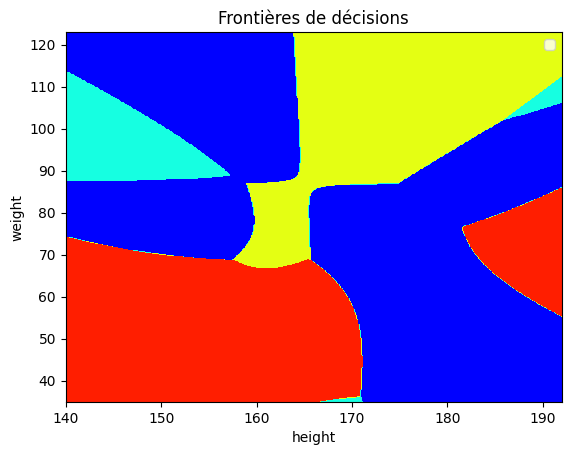

In [8]:
plt.figure()
plt.contourf(height, weight, Z.T, 3, cmap = "jet")


plt.title("Frontières de décisions")
plt.xlabel("height")
plt.ylabel("weight")

plt.legend()

In [9]:
preds = np.zeros((metaDataClean[:].shape[0]))

for i in range(metaDataClean[:].shape[0]):
    index_height = (np.abs(height - metaDataClean[i][2])).argmin()
    index_weight = (np.abs(weight - metaDataClean[i][3])).argmin()
    preds[i]= np.argmax([healthy.shape[0]*density_healthy[index_height, index_weight], myocardial_infarction.shape[0]*density_myocardial_infarction[index_height, index_weight], dilated_cardiomyopathy.shape[0]*density_dilated_cardiomyopathy[index_height, index_weight], hypertrophic_cardiomyopathy.shape[0]*density_hypertrophic_cardiomyopathy[index_height, index_weight], arrhythmogenic_right_ventricular_dysplasia.shape[0]*density_arrhythmogenic_right_ventricular_dysplasia[index_height, index_weight]])

gt = metaDataClean[:, 1].astype('int')

Text(0.5, 1.0, 'Prediction repartition for naïve bayes. 35.00% accuracy on the training set')

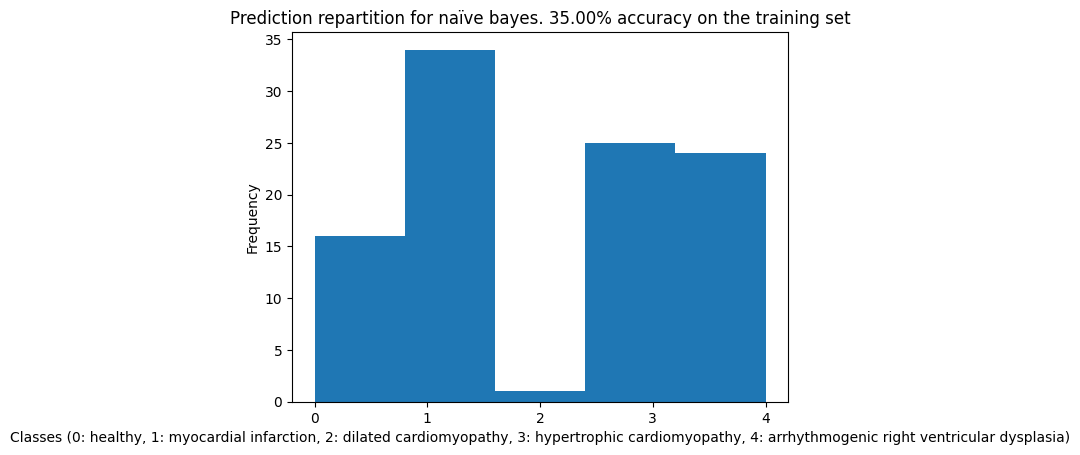

In [14]:
accuracynb = accuracy(preds, gt)
plt.hist(np.array(preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')
plt.title("Prediction repartition for naïve bayes. {:.2f}% accuracy on the training set".format(accuracynb*100))

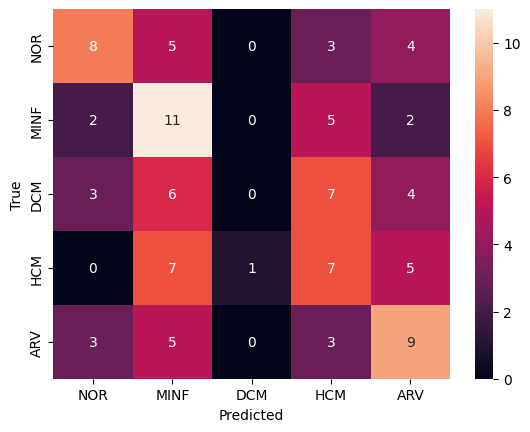

In [13]:
cm = confusion_matrix(gt, preds, labels=[0,1,2,3,4])
heatmap(cm, annot=True, fmt='d', xticklabels=['NOR','MINF','DCM','HCM','ARV'], yticklabels=['NOR','MINF','DCM','HCM','ARV'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Let us compute predictions on the test set

In [ ]:
metaDataTest = pd.read_csv('../metaDataTest.csv')
metaDataTestClean = metaDataTest.iloc

preds = np.zeros((metaDataTestClean[:].shape[0]))

for i in range(metaDataTestClean[:].shape[0]):
    h, w = (np.abs(height - metaDataTestClean[i][1])).argmin(), (np.abs(weight - metaDataTestClean[i][2])).argmin()
    preds[i]= np.argmax([healthy.shape[0]*density_healthy[h, w], myocardial_infarction.shape[0]*density_myocardial_infarction[h, w], dilated_cardiomyopathy.shape[0]*density_dilated_cardiomyopathy[h, w], hypertrophic_cardiomyopathy.shape[0]*density_hypertrophic_cardiomyopathy[h, w], arrhythmogenic_right_ventricular_dysplasia.shape[0]*density_arrhythmogenic_right_ventricular_dysplasia[h, w]])

preds_int = preds.astype('int')

Text(0.5, 1.0, 'Prediction repartition for naïve bayes - test set')

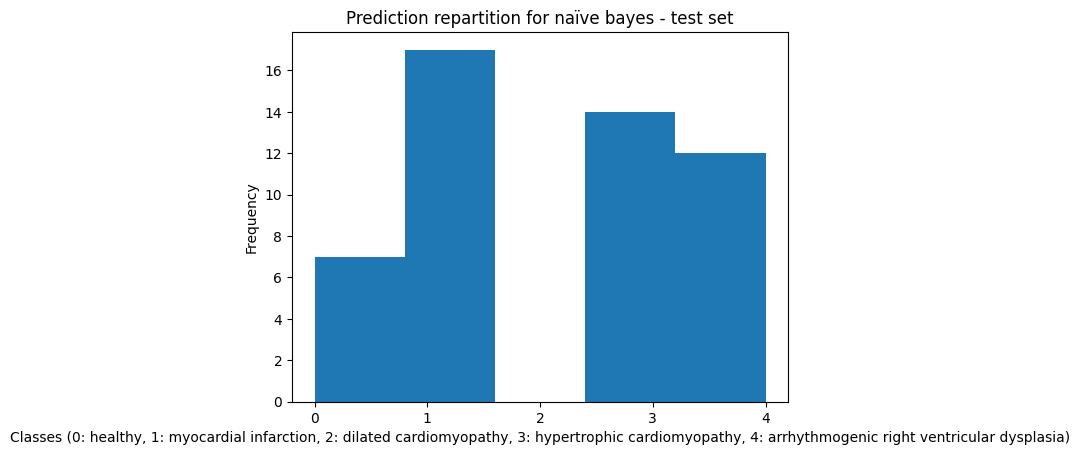

In [ ]:
plt.hist(np.array(preds_int), bins=5)
plt.xticks([0,1,2,3,4])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')
plt.title("Prediction repartition for naïve bayes - test set")

### Saving preds on csv

In [ ]:
preds_int

array([3, 4, 3, 1, 1, 3, 1, 3, 3, 4, 1, 3, 4, 1, 0, 4, 3, 1, 4, 0, 4, 0,
       3, 3, 3, 4, 1, 1, 0, 1, 3, 4, 1, 3, 4, 3, 1, 1, 0, 4, 0, 1, 3, 4,
       4, 0, 1, 1, 1, 1])

In [ ]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = preds_int
df.to_csv("../SampleSubmission.csv", index=False)